<a href="https://colab.research.google.com/github/sharmaanj200/Computer-Vision-IGDTUW/blob/main/Assignment_3_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Question 1

import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_batch(filename):
    batch = unpickle(filename)
    features = batch[b'data'].reshape((len(batch[b'data']), 32, 32, 3), order='F')
    labels = batch[b'labels']
    return features, labels

def downsample(features, labels, num_samples=500):
    # Assure each class has the same number of images
    unique_classes = set(labels)
    downsampled_features = []
    downsampled_labels = []
    for cls in unique_classes:
        class_indices = [i for i, label in enumerate(labels) if label == cls]
        downsampled_indices = np.random.choice(class_indices, num_samples, replace=False)
        downsampled_features.extend(features[downsampled_indices])
        downsampled_labels.extend([cls for _ in range(num_samples)])
    return np.array(downsampled_features), np.array(downsampled_labels)

# Load all training batches
all_features = []
all_labels = []
for i in range(1, 6):
    features, labels = load_batch(f'/content/drive/MyDrive/cifar-10-batches-py/data_batch_{i}')
    all_features.append(features)
    all_labels.append(labels)
train_features = np.concatenate(all_features)
train_labels = np.concatenate(all_labels)

# Downsample training data
train_features, train_labels = downsample(train_features, train_labels, 500)

# Load test batch
test_features, test_labels = load_batch('/content/drive/MyDrive/cifar-10-batches-py/test_batch')
# Downsample test data
test_features, test_labels = downsample(test_features, test_labels, 100)

# Flatten the images for KNN
X_train = train_features.reshape((train_features.shape[0], -1))
X_test = test_features.reshape((test_features.shape[0], -1))

Test Loss: 1.8421446505706722


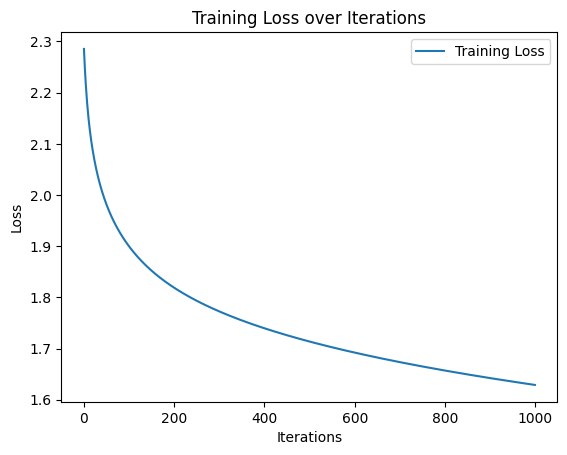

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Split the downsampled data into train, validate, and test sets
def split_data(features, labels, train_size, val_size, test_size):
    num_samples = len(labels)
    indices = np.random.permutation(num_samples)
    train_end = int(train_size * num_samples)
    val_end = train_end + int(val_size * num_samples)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    X_train = features[train_indices].reshape((len(train_indices), -1))
    y_train = labels[train_indices]
    X_val = features[val_indices].reshape((len(val_indices), -1))
    y_val = labels[val_indices]
    X_test = features[test_indices].reshape((len(test_indices), -1))
    y_test = labels[test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Split the downsampled data into train, validate, and test sets
train_features, train_labels, val_features, val_labels, test_features, test_labels = split_data(train_features, train_labels, 0.7, 0.2, 0.1)

# Step 2: Normalize the data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# Step 3: Initialize weights and bias
np.random.seed(0)
num_classes = 10
num_features = 32 * 32 * 3
learning_rate = 0.001
reg_strength = 0.01  # Regularization strength

W = np.random.randn(num_classes, num_features) * 0.001
b = np.zeros(num_classes)

# Step 4: Define the Cross-Entropy Loss Function with L2 Regularization
def compute_loss(X, y, W, b, reg):
    scores = np.dot(X, W.T) + b
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    correct_logprobs = -np.log(probs[range(X.shape[0]), y])
    data_loss = np.sum(correct_logprobs)
    reg_loss = 0.5 * reg * np.sum(W * W)
    return (1. / X.shape[0]) * data_loss + reg_loss

# Step 5: Implement Gradient Descent with L2 Regularization
def train(X, y, W, b, num_iters=100, learning_rate=0.01, reg_strength=0.01):
    loss_history = []

    for i in range(num_iters):
        scores = np.dot(X, W.T) + b
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        dscores = probs
        dscores[range(X.shape[0]), y] -= 1
        dscores /= X.shape[0]

        dW = np.dot(dscores.T, X) + reg_strength * W
        db = np.sum(dscores, axis=0)

        W -= learning_rate * dW
        b -= learning_rate * db

        loss = compute_loss(X, y, W, b, reg_strength)
        loss_history.append(loss)

    return W, b, loss_history

# Step 6: Train the Model
W, b, loss_history = train(train_features, train_labels, W, b, num_iters=1000, learning_rate=learning_rate, reg_strength=reg_strength)

# Step 7: Test the Model
test_loss = compute_loss(test_features, test_labels, W, b, reg_strength)
print("Test Loss:", test_loss)

# Step 8: Plot Learning Curves
plt.plot(range(len(loss_history)), loss_history, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.show()

Epoch 1/10
125/125 [==============================] - 9s 16ms/step - loss: 3.8860 - accuracy: 0.1045 - val_loss: 2.3033 - val_accuracy: 0.0850
Epoch 2/10
125/125 [==============================] - 1s 11ms/step - loss: 2.3026 - accuracy: 0.0960 - val_loss: 2.3037 - val_accuracy: 0.0850
Epoch 3/10
125/125 [==============================] - 1s 10ms/step - loss: 2.3026 - accuracy: 0.1030 - val_loss: 2.3041 - val_accuracy: 0.0810
Epoch 4/10
125/125 [==============================] - 1s 7ms/step - loss: 2.3025 - accuracy: 0.1010 - val_loss: 2.3044 - val_accuracy: 0.0810
Epoch 5/10
125/125 [==============================] - 1s 9ms/step - loss: 2.3025 - accuracy: 0.0993 - val_loss: 2.3046 - val_accuracy: 0.0810
Epoch 6/10
125/125 [==============================] - 1s 10ms/step - loss: 2.3026 - accuracy: 0.1005 - val_loss: 2.3049 - val_accuracy: 0.0810
Epoch 7/10
125/125 [==============================] - 1s 8ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3050 - val_accuracy: 0.0810
Ep

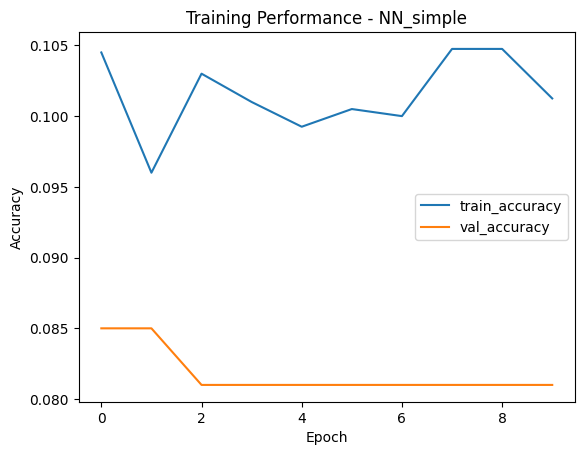

In [6]:
# Question 2:

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Define function to split data into train and validation sets
def split_data(features, labels, val_size):
    return train_test_split(features, labels, test_size=val_size, random_state=42)

# Prepare data
X_train, X_val, y_train, y_val = split_data(train_features, train_labels, val_size=0.2)

# Flatten the input data
X_train_flattened = X_train.reshape(len(X_train), -1)
X_val_flattened = X_val.reshape(len(X_val), -1)

# Define the simple NN model architecture
NN_simple = Sequential()
NN_simple.add(Dense(10, input_shape=X_train_flattened.shape[1:], activation='relu'))
NN_simple.add(Dense(10, activation='relu'))
NN_simple.add(Dense(10, activation='relu'))
NN_simple.add(Dense(10, activation='softmax'))

# Compile the model
NN_simple.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the simple model
history_simple = NN_simple.fit(X_train_flattened, y_train, validation_data=(X_val_flattened, y_val), epochs=10)

# Plot training history
plt.plot(history_simple.history['accuracy'], label='train_accuracy')
plt.plot(history_simple.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Performance - NN_simple')
plt.legend()
plt.show()


Epoch 1/10
125/125 [==============================] - 4s 13ms/step - loss: 12.3553 - accuracy: 0.1177 - val_loss: 2.3005 - val_accuracy: 0.1370
Epoch 2/10
125/125 [==============================] - 1s 7ms/step - loss: 2.3148 - accuracy: 0.1050 - val_loss: 2.3000 - val_accuracy: 0.1010
Epoch 3/10
125/125 [==============================] - 1s 7ms/step - loss: 2.3082 - accuracy: 0.1065 - val_loss: 2.3050 - val_accuracy: 0.0910
Epoch 4/10
125/125 [==============================] - 1s 7ms/step - loss: 2.2980 - accuracy: 0.1077 - val_loss: 2.2952 - val_accuracy: 0.1040
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 2.3010 - accuracy: 0.1115 - val_loss: 2.3042 - val_accuracy: 0.0850
Epoch 6/10
125/125 [==============================] - 1s 6ms/step - loss: 2.2982 - accuracy: 0.1082 - val_loss: 2.2995 - val_accuracy: 0.0870
Epoch 7/10
125/125 [==============================] - 1s 8ms/step - loss: 2.2973 - accuracy: 0.1103 - val_loss: 2.3048 - val_accuracy: 0.0850
Epoc

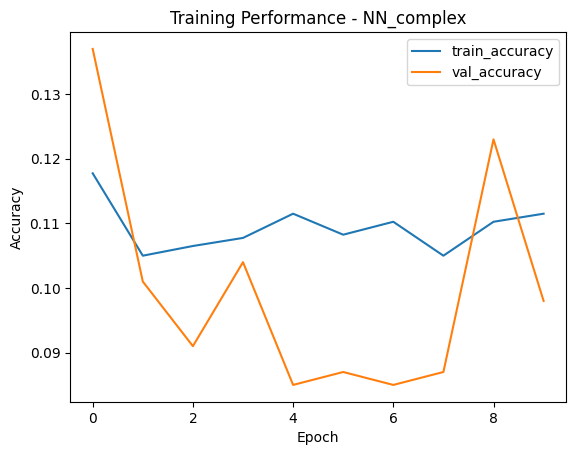

In [12]:
# Prepare data
X_train, X_val, y_train, y_val = split_data(train_features, train_labels, val_size=0.2)

# Flatten the input data
X_train_flattened = X_train.reshape(len(X_train), -1)
X_val_flattened = X_val.reshape(len(X_val), -1)

# Define the complex NN model architecture
NN_complex = Sequential()
NN_complex.add(Dense(60, input_shape=X_train_flattened.shape[1:], activation='relu'))
NN_complex.add(Dense(50, activation='relu'))
NN_complex.add(Dense(40, activation='relu'))
NN_complex.add(Dense(30, activation='relu'))
NN_complex.add(Dense(20, activation='relu'))
NN_complex.add(Dense(10, activation='softmax'))

# Compile the model
NN_complex.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history_complex = NN_complex.fit(X_train_flattened, y_train, validation_data=(X_val_flattened, y_val), epochs=10)

# Plot training history
plt.plot(history_complex.history['accuracy'], label='train_accuracy')
plt.plot(history_complex.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Performance - NN_complex')
plt.legend()
plt.show()


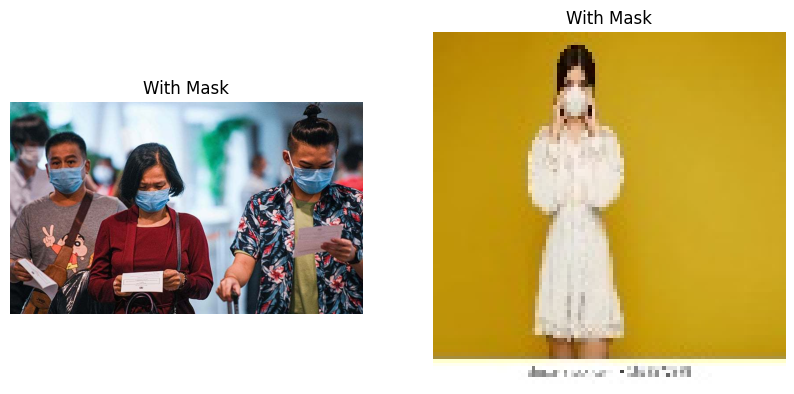

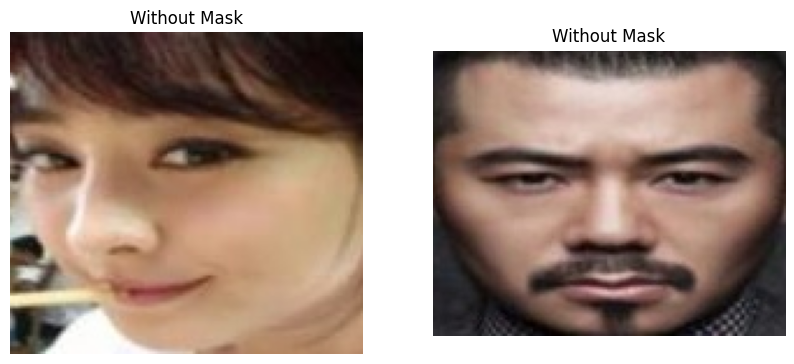

In [14]:
# Question 3:
from google.colab import drive
from tensorflow.keras.preprocessing.image import load_img
import os
import random
import matplotlib.pyplot as plt

# Path to the dataset in Google Drive
dataset_path = '/content/drive/MyDrive/face-mask-dataset'

# Display random images from the 'with_mask' folder
with_mask_folder = os.path.join(dataset_path, 'with_mask')
with_mask_images = os.listdir(with_mask_folder)
random.shuffle(with_mask_images)  # Shuffle the images
sample_with_mask_images = with_mask_images[:2]  # Select two random images

plt.figure(figsize=(10, 5))
for i, image in enumerate(sample_with_mask_images, 1):
    image_path = os.path.join(with_mask_folder, image)
    plt.subplot(1, 2, i)
    plt.imshow(load_img(image_path))
    plt.title('With Mask')
    plt.axis('off')
plt.show()

# Display random images from the 'without_mask' folder
without_mask_folder = os.path.join(dataset_path, 'without_mask')
without_mask_images = os.listdir(without_mask_folder)
random.shuffle(without_mask_images)  # Shuffle the images
sample_without_mask_images = without_mask_images[:2]  # Select two random images

plt.figure(figsize=(10, 5))
for i, image in enumerate(sample_without_mask_images, 1):
    image_path = os.path.join(without_mask_folder, image)
    plt.subplot(1, 2, i)
    plt.imshow(load_img(image_path))
    plt.title('Without Mask')
    plt.axis('off')
plt.show()

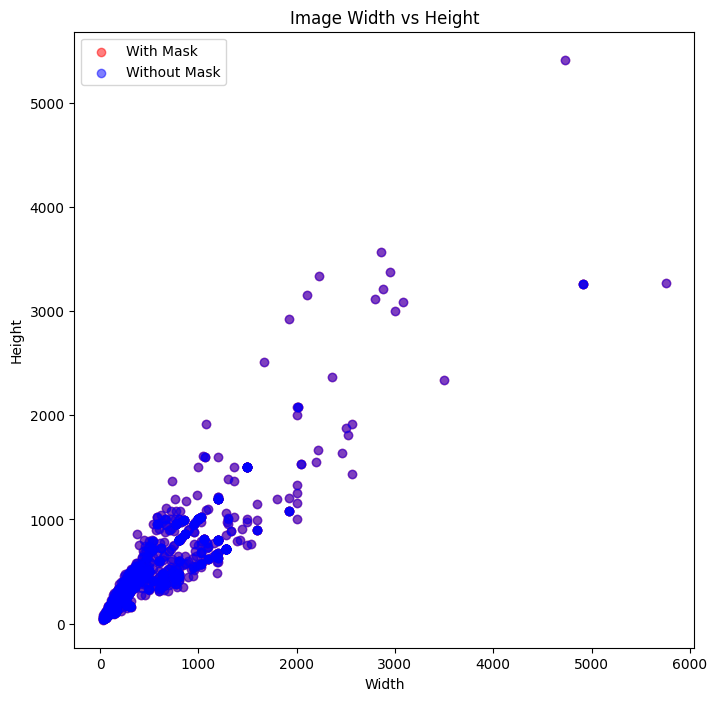

In [15]:
# Question 4
import os
import cv2
import matplotlib.pyplot as plt

# Path to the dataset in Google Drive
dataset_path = '/content/drive/MyDrive/face-mask-dataset'

# Gather image width and height data
widths = []
heights = []
mask_folder = os.path.join(dataset_path, 'with_mask')
no_mask_folder = os.path.join(dataset_path, 'without_mask')

for image_file in os.listdir(mask_folder):
    image = cv2.imread(os.path.join(mask_folder, image_file))
    height, width, _ = image.shape
    widths.append(width)
    heights.append(height)

for image_file in os.listdir(no_mask_folder):
    image = cv2.imread(os.path.join(no_mask_folder, image_file))
    height, width, _ = image.shape
    widths.append(width)
    heights.append(height)

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(widths, heights, c='red', label='With Mask', alpha=0.5)
plt.scatter(widths, heights, c='blue', label='Without Mask', alpha=0.5)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Width vs Height')
plt.legend()
plt.show()

In [16]:
import cv2
import os
import cv2
import matplotlib.pyplot as plt

# Path to the dataset in Google Drive
dataset_path = '/content/drive/MyDrive/face-mask-dataset'

# Resizing and Cropping Strategies
resized_with_mask_images = []
resized_without_mask_images = []
cropped_with_mask_images = []
cropped_without_mask_images = []

# Resizing Images to 224x224
for image_file in os.listdir(mask_folder):
    image = cv2.imread(os.path.join(mask_folder, image_file))
    resized_image = cv2.resize(image, (224, 224))  # Resize the image to 224x224
    resized_with_mask_images.append(resized_image)

for image_file in os.listdir(no_mask_folder):
    image = cv2.imread(os.path.join(no_mask_folder, image_file))
    resized_image = cv2.resize(image, (224, 224))  # Resize the image to 224x224
    resized_without_mask_images.append(resized_image)

# Cropping Images to 224x224
for image_file in os.listdir(mask_folder):
    image = cv2.imread(os.path.join(mask_folder, image_file))
    height, width, _ = image.shape
    start_x = (width - 224) // 2  # Calculate the starting x-coordinate for center cropping
    start_y = (height - 224) // 2  # Calculate the starting y-coordinate for center cropping
    cropped_image = image[start_y:start_y + 224, start_x:start_x + 224]  # Crop the central region of the image to 224x224
    cropped_with_mask_images.append(cropped_image)

for image_file in os.listdir(no_mask_folder):
    image = cv2.imread(os.path.join(no_mask_folder, image_file))
    height, width, _ = image.shape
    start_x = (width - 224) // 2  # Calculate the starting x-coordinate for center cropping
    start_y = (height - 224) // 2  # Calculate the starting y-coordinate for center cropping
    cropped_image = image[start_y:start_y+224, start_x:start_x+224]  # Crop the central region of the image to 224x224
    cropped_without_mask_images.append(cropped_image)

resized_with_mask_dir = '/content/resized_with_mask'
resized_without_mask_dir = '/content/resized_without_mask'
cropped_with_mask_dir = '/content/cropped_with_mask'
cropped_without_mask_dir = '/content/cropped_without_mask'

# Create the directories if they don't exist
os.makedirs(resized_with_mask_dir, exist_ok=True)
os.makedirs(resized_without_mask_dir, exist_ok=True)
os.makedirs(cropped_with_mask_dir, exist_ok=True)
os.makedirs(cropped_without_mask_dir, exist_ok=True)

# Save the resized images
for i, img in enumerate(resized_with_mask_images):
    cv2.imwrite(os.path.join(resized_with_mask_dir, f"resized_with_mask_{i}.jpg"), img)

for i, img in enumerate(resized_without_mask_images):
    cv2.imwrite(os.path.join(resized_without_mask_dir, f"resized_without_mask_{i}.jpg"), img)

# Save the cropped images
for i, img in enumerate(cropped_with_mask_images):
    cv2.imwrite(os.path.join(cropped_with_mask_dir, f"cropped_with_mask_{i}.jpg"), img)

for i, img in enumerate(cropped_without_mask_images):
    cv2.imwrite(os.path.join(cropped_without_mask_dir, f"cropped_without_mask_{i}.jpg"), img)

print("Resized and cropped images saved successfully.")

Resized and cropped images saved successfully.


In [20]:
import cv2
import os
import numpy as np

# Directory paths for resized images with and without masks
resized_with_mask_dir = '/content/resized_with_mask'
resized_without_mask_dir = '/content/resized_without_mask'

# Load resized images with masks
X_resize_with_mask = []
y_resize_with_mask = []
for img_path in os.listdir(resized_with_mask_dir):
    img = cv2.imread(os.path.join(resized_with_mask_dir, img_path))
    X_resize_with_mask.append(img)
    # Append the label for images with masks (example: 1 for 'with_mask')
    y_resize_with_mask.append(1)

X_resize_without_mask = []
y_resize_without_mask = []
for img_path in os.listdir(resized_without_mask_dir):
    img = cv2.imread(os.path.join(resized_without_mask_dir, img_path))
    X_resize_without_mask.append(img)
    y_resize_without_mask.append(0)

X_resize = np.array(X_resize_with_mask + X_resize_without_mask)
y_resize = np.array(y_resize_with_mask + y_resize_without_mask)

In [34]:
cropped_with_mask_dir = '/content/cropped_with_mask'
cropped_without_mask_dir = '/content/cropped_without_mask'

# Load cropped images with masks
X_crop_with_mask = []
y_crop_with_mask = []
for img_path in os.listdir(cropped_with_mask_dir):
    img = cv2.imread(os.path.join(cropped_with_mask_dir, img_path))
    X_crop_with_mask.append(img)
    # Append the label for images with masks (example: 1 for 'with_mask')
    y_crop_with_mask.append(1)

# Load cropped images without masks
X_crop_without_mask = []
y_crop_without_mask = []
for img_path in os.listdir(cropped_without_mask_dir):
    img = cv2.imread(os.path.join(cropped_without_mask_dir, img_path))
    X_crop_without_mask.append(img)
    # Append the label for images without masks (example: 0 for 'without_mask')
    y_crop_without_mask.append(0)

In [36]:
# Question 5:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt

# Define your custom neural network architecture, compile it, and define learning rate
def custom_nn_model():
    model = tf.keras.models.Sequential([
        # Define your layers as needed
        tf.keras.layers.Flatten(input_shape=(224, 224, 3)),  # Example input shape for 224x224 RGB images
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Assuming you have X_resize, y_resize for the resize dataset and X_crop, y_crop for the crop dataset loaded and prepared

# Split the resized dataset using stratified sampling
X_resize_train, X_resize_test, y_resize_train, y_resize_test = train_test_split(X_resize, y_resize, test_size=0.2, stratify=y_resize, random_state=42)
X_resize_train, X_resize_val, y_resize_train, y_resize_val = train_test_split(X_resize_train, y_resize_train, test_size=0.2, stratify=y_resize_train, random_state=42)

# Split the crop dataset using stratified sampling
X_crop_train, X_crop_test, y_crop_train, y_crop_test = train_test_split(X_crop, y_crop, test_size=0.2, stratify=y_crop, random_state=42)
X_crop_train, X_crop_val, y_crop_train, y_crop_val = train_test_split(X_crop_train, y_crop_train, test_size=0.2, stratify=y_crop_train, random_state=42)

# Train and evaluate the model for the resize dataset
model_resize = custom_nn_model()
history_resize = model_resize.fit(X_resize_train, y_resize_train, validation_data=(X_resize_val, y_resize_val), epochs=20)

# Evaluate the model on test data for the resize dataset
loss_resize, accuracy_resize = model_resize.evaluate(X_resize_test, y_resize_test)
y_resize_pred = model_resize.predict_classes(X_resize_test)
report_resize = classification_report(y_resize_test, y_resize_pred, output_dict=True)

# Train and evaluate the model for the crop dataset
model_crop = custom_nn_model()
history_crop = model_crop.fit(X_crop_train, y_crop_train, validation_data=(X_crop_val, y_crop_val), epochs=20)

# Evaluate the model on test data for the crop dataset
loss_crop, accuracy_crop = model_crop.evaluate(X_crop_test, y_crop_test)
y_crop_pred = model_crop.predict_classes(X_crop_test)
report_crop = classification_report(y_crop_test, y_crop_pred, output_dict=True)

# Display learning plots
plt.plot(history_resize.history['accuracy'], label='accuracy')
plt.plot(history_resize.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_crop.history['accuracy'], label='accuracy')
plt.plot(history_crop.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Output precision, recall, F1-score for each class and average accuracy
print("Resize Dataset Metrics:")
print(classification_report(y_resize_test, y_resize_pred))
print("Average Accuracy for Resize Dataset:", accuracy_resize)

print("Crop Dataset Metrics:")
print(classification_report(y_crop_test, y_crop_pred))
print("Average Accuracy for Crop Dataset:", accuracy_crop)

# Compare performance using bar plots
accuracy_values = [accuracy_resize, accuracy_crop]
precision_values = [report_resize['weighted avg']['precision'], report_crop['weighted avg']['precision']]
recall_values = [report_resize['weighted avg']['recall'], report_crop['weighted avg']['recall']]
f1_values = [report_resize['weighted avg']['f1-score'], report_crop['weighted avg']['f1-score']]

labels = ['Resize Dataset', 'Crop Dataset']

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
bar1 = ax.bar(x - 1.5*width, accuracy_values, width, label='Accuracy')
bar2 = ax.bar(x - 0.5*width, precision_values, width, label='Precision')
bar3 = ax.bar(x + 0.5*width, recall_values, width, label='Recall')
bar4 = ax.bar(x + 1.5*width, f1_values, width, label='F1-Score')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Metrics')
ax.set_title('Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the bar plot
plt.show()

Epoch 1/20
77/77 [==============================] - 33s 417ms/step - loss: 2400.4653 - accuracy: 0.7189 - val_loss: 902.3297 - val_accuracy: 0.7031
Epoch 2/20
77/77 [==============================] - 33s 430ms/step - loss: 568.4083 - accuracy: 0.8237 - val_loss: 613.6412 - val_accuracy: 0.8320
Epoch 3/20
77/77 [==============================] - 37s 473ms/step - loss: 363.4836 - accuracy: 0.8641 - val_loss: 228.9331 - val_accuracy: 0.9021
Epoch 4/20
77/77 [==============================] - 32s 415ms/step - loss: 239.8782 - accuracy: 0.8809 - val_loss: 350.9608 - val_accuracy: 0.8418
Epoch 5/20
77/77 [==============================] - 32s 413ms/step - loss: 208.0986 - accuracy: 0.8915 - val_loss: 139.9610 - val_accuracy: 0.9038
Epoch 6/20
77/77 [==============================] - 33s 430ms/step - loss: 233.8402 - accuracy: 0.8629 - val_loss: 488.0657 - val_accuracy: 0.8026
Epoch 7/20
77/77 [==============================] - 32s 413ms/step - loss: 253.6400 - accuracy: 0.8650 - val_loss: 14

AttributeError: 'Sequential' object has no attribute 'predict_classes'